# **Restricted Boltzmann Machine(RBM)**

## Load the MINIST dataset :

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

BATCHSIZE = 16
VISIBLE_UNITS = 28*28
HIDDEN_UNITS = 100
CD_K = 1
EPOCHS = 20

# load datasets
tr_dataset = datasets.MNIST('data/mnist', train=True, transform=transforms.ToTensor(), download=True)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCHSIZE)

ts_dataset = datasets.MNIST('data/mnist', train=False, transform=transforms.ToTensor(), download=True)
ts_loader = torch.utils.data.DataLoader(ts_dataset, batch_size=BATCHSIZE)

## Define RBM model

In [2]:
class RBM():
  def __init__(self, n_visible=VISIBLE_UNITS, n_hidden=HIDDEN_UNITS, k=CD_K, lr=1e-1, momentum_rate=0.5, w_decay=1e-4):
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.k = k
    self.lr = lr
    self.momentum_rate = momentum_rate
    self.w_decay = w_decay
  
    #self.w = torch.randn(n_visible, n_hidden) * 0.1
    self.w = torch.normal(0, 0.01, size = (n_visible, n_hidden))
    self.visible_b = torch.ones(n_visible) * 0.5
    self.hidden_b = torch.zeros(n_hidden)

    self.w_momentum = torch.zeros(n_visible, n_hidden)
    self.visible_b_momentum = torch.zeros(n_visible)
    self.hidden_b_momentum = torch.zeros(n_hidden)

  def _sample(self, p, size):
    return (p >= torch.rand(size)).float()

  def v2h(self, visible_p):
    hidden_activations = torch.matmul(visible_p, self.w) + self.hidden_b
    hidden_p = 1 / (1 + torch.exp(-hidden_activations))
    return hidden_p, self._sample(hidden_p, self.n_hidden)

  def h2v(self, hidden):
    visible_activations = torch.matmul(hidden, self.w.t()) + self.visible_b
    visible_p = 1 / (1 + torch.exp(-visible_activations))
    return visible_p, self._sample(visible_p, self.n_visible)

  def cd(self, input):
    # wake part
    pos_hidden_p, pos_hidden = self.v2h(input)
    wake = torch.matmul(input.t(), pos_hidden_p)

    # dream part
    neg_hidden = pos_hidden
    for step in range(self.k):
      recon_visible_p, _ = self.h2v(neg_hidden)
      neg_hidden_p, neg_hidden = self.v2h(recon_visible_p)
    
    dream = torch.matmul(recon_visible_p.t(), neg_hidden_p)
    Delta_w = wake - dream

    #update parameters
    self.w_momentum = self.momentum_rate*(self.w_momentum) + Delta_w
    self.visible_b_momentum = self.momentum_rate*(self.visible_b_momentum) + torch.sum(input - recon_visible_p, dim=0)
    self.hidden_b_momentum = self.momentum_rate*(self.hidden_b_momentum) + torch.sum(pos_hidden_p - neg_hidden_p, dim=0)


    batch_size = input.size(0)
    self.w += self.w_momentum * self.lr / batch_size
    self.visible_b += self.visible_b_momentum * self.lr / batch_size
    self.hidden_b += self.hidden_b_momentum * self.lr / batch_size

    self.w -= self.w * self.w_decay
    #reconstruciton error
    err = torch.sum((input - recon_visible_p)**2)

    return err, input, recon_visible_p, self._sample(recon_visible_p, self.n_visible)

  def train(self, n_epochs, tr_loader, verbose=1):
    # training RBM
    for epoch in range(n_epochs):
      epoch_err = 0.0

      for batch, _ in tr_loader:
        batch = batch.view(len(batch), self.n_visible)
        batch_err, data, recon_data_p, recon_data = self.cd(batch)
        epoch_err += batch_err
      if verbose:
        print("Epoch Error (epoch=%d): %.4f" % (epoch+1, epoch_err))


## Train RBM model

In [3]:
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K)
rbm.train(EPOCHS, tr_loader)

Epoch Error (epoch=1): 1021523.6875
Epoch Error (epoch=2): 767024.3750
Epoch Error (epoch=3): 723450.5625
Epoch Error (epoch=4): 701298.6250
Epoch Error (epoch=5): 689947.6875
Epoch Error (epoch=6): 680939.1875
Epoch Error (epoch=7): 676457.7500
Epoch Error (epoch=8): 671306.7500
Epoch Error (epoch=9): 667771.5625
Epoch Error (epoch=10): 664162.6250
Epoch Error (epoch=11): 662328.1250
Epoch Error (epoch=12): 661284.8750
Epoch Error (epoch=13): 660192.4375
Epoch Error (epoch=14): 657834.4375
Epoch Error (epoch=15): 657243.8750
Epoch Error (epoch=16): 656101.8125
Epoch Error (epoch=17): 655167.7500
Epoch Error (epoch=18): 653177.2500
Epoch Error (epoch=19): 652208.1250
Epoch Error (epoch=20): 651819.7500


## Define a classification model by placing a softmax layer after the RBM

In [4]:
class RBM_Net(torch.nn.Module):
    def __init__(self, rbm, input_dim, output_dim):
        super(RBM_Net, self).__init__()
        self.rbm = rbm
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = self.rbm.v2h(x)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        for epoch in range(epochs):
          for i, (batch, labels) in enumerate(tr_loader):
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = clf(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
          
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          print("Epoch:{}. loss :{}. Accuracy:{}".format(epoch+1, loss.item(), accuracy))
      
        return y_true, y_pred

rbm_Model = RBM_Net(rbm, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(rbm_Model.parameters(), lr=1e-3)

### Train the classifier :

In [5]:
y_true, y_pred = rbm_Model.train(tr_loader, ts_loader, optimizer, rbm_Model, criterion)

Epoch:1. loss :0.1017611026763916. Accuracy:91.0999984741211
Epoch:2. loss :0.06547491252422333. Accuracy:92.00999450683594
Epoch:3. loss :0.055846866220235825. Accuracy:92.38999938964844
Epoch:4. loss :0.05155394226312637. Accuracy:92.5999984741211
Epoch:5. loss :0.04908938705921173. Accuracy:92.7699966430664
Epoch:6. loss :0.047431766986846924. Accuracy:92.88999938964844
Epoch:7. loss :0.04619205743074417. Accuracy:92.8699951171875
Epoch:8. loss :0.04519832506775856. Accuracy:92.9000015258789
Epoch:9. loss :0.04436606913805008. Accuracy:92.87999725341797
Epoch:10. loss :0.04365047067403793. Accuracy:92.90999603271484


### Build the confusion matrix :

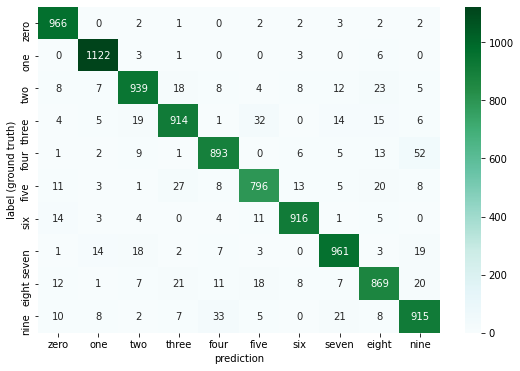

In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

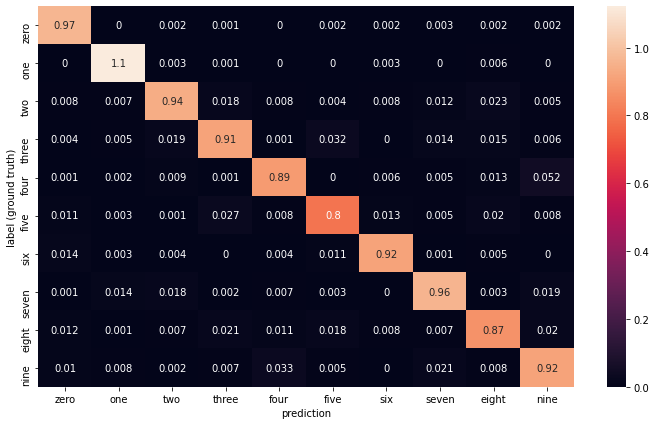

In [7]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Define a classification model taking the RBM hidden states as embbedings.

In [8]:
class EMB_RBM_Net(torch.nn.Module):
    def __init__(self, rbm, input_dim, output_dim):
        super(EMB_RBM_Net, self).__init__()
        self.rbm = rbm
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(self.rbm.w, 0, 1))
        self.fl1.bias.data.copy_(self.rbm.hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        for epoch in range(epochs):
          for i, (batch, labels) in enumerate(tr_loader):
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = clf(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
          
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          print("Epoch:{}. loss :{}. Accuracy:{}".format(epoch+1, loss.item(), accuracy))
        return y_true, y_pred

emb_rbm_Model = EMB_RBM_Net(rbm, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_rbm_Model.parameters(), lr=5e-4)

### Train the classifier :

In [9]:
y_true, y_pred = emb_rbm_Model.train(tr_loader, ts_loader, optimizer, emb_rbm_Model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:1. loss :0.11394879221916199. Accuracy:92.55999755859375
Epoch:2. loss :0.047506727278232574. Accuracy:94.36000061035156
Epoch:3. loss :0.030055200681090355. Accuracy:95.08000183105469
Epoch:4. loss :0.02331298403441906. Accuracy:95.52999877929688
Epoch:5. loss :0.0196814127266407. Accuracy:95.72000122070312
Epoch:6. loss :0.01701994612812996. Accuracy:95.97000122070312
Epoch:7. loss :0.014943089336156845. Accuracy:96.2300033569336
Epoch:8. loss :0.013236884027719498. Accuracy:96.43000030517578
Epoch:9. loss :0.011981232091784477. Accuracy:96.51000213623047
Epoch:10. loss :0.011290544643998146. Accuracy:96.68000030517578


### Check the pretrained RBM layer weights to make sure it is updated :

In [10]:
emb_rbm_Model.fl1.weight.data == torch.transpose(rbm.w, 0, 1)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [11]:
(emb_rbm_Model.fl1.weight.data == torch.transpose(rbm.w, 0, 1)).all()

tensor(False)

### Build the confusion matrix :

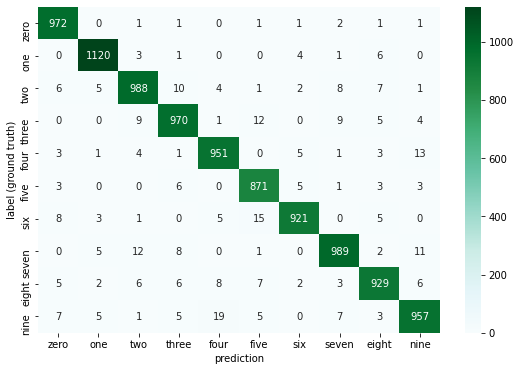

In [12]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

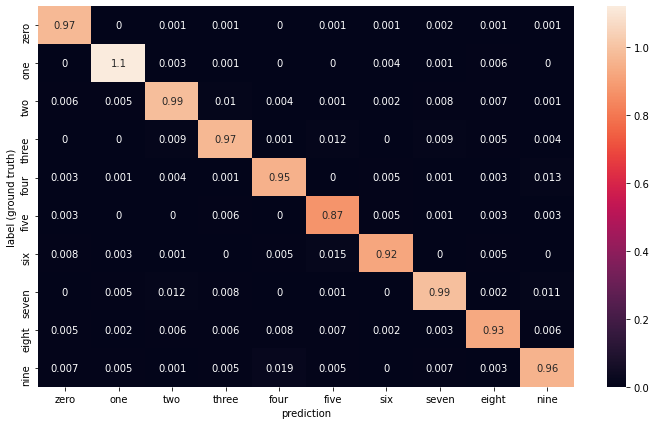

In [13]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

# **Deep Belief network(DBN)** :

## Define DBN model:

In [14]:
class DBN(nn.Module):
  def __init__(self, n_visible=28*28, n_hiddens=[HIDDEN_UNITS, HIDDEN_UNITS], k=1):
    super(DBN, self).__init__()
    
    self.n_layers = len(n_hiddens)
    self.rbm_layers = []
  
    # creating different RBM layers
    for i in range(self.n_layers):
      n_input = 0;
      if i == 0:
        n_input = n_visible
      else:
        n_input = n_hiddens[i-1]
      rbm = RBM(n_input, n_hiddens[i], k)
      self.rbm_layers.append(rbm)

  def forward(self, input):
    '''
    running the forward pass
    '''
    visible = input 
    for i in range(len(self.rbm_layers)):
      hidden_p, hidden = self.rbm_layers[i].v2h(visible)
      visible = hidden_p
    return hidden_p, hidden

  def reconstruct(self, input):
    '''
    go till the final layer and then reconstruct
    '''
    # visible_p = input

    # for i in range(len(self.rbm_layers)):
    #   hidden_p, h = self.rbm_layers[i].v2h(visible_p)
    #   visible_p = hidden_p
    hidden_p, h = self.forward(input)
    hidden = h

    for i in range(len(self.rbm_layers)-1,-1,-1):
      recon_visible_p, recon_visible = self.rbm_layers[i].h2v(hidden)
      hidden = recon_visible
    return recon_visible_p, recon_visible

  def train(self,  train_data, train_labels, n_epochs=20, batch_size=16, debug=True):
    verbose = 1
    transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
    train_data = torch.stack([transform(data) for data in train_data]).squeeze()
    tmp = train_data
    for i in range(len(self.rbm_layers)):
      if debug:
        print("-"*40)
        print("Training rbm layer number {}".format(i+1))
      
      # Transform raw input data for rbm_layers 0:
      
      if i == len(self.rbm_layers)-1:
        verbose = 0

      tensor_data = tmp.type(torch.FloatTensor)
      tensor_label = train_labels.type(torch.FloatTensor)
      dataset = torch.utils.data.TensorDataset(tensor_data, tensor_label)
      data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

      if not debug:
        verbose = 0
      self.rbm_layers[i].train(n_epochs, data_loader, verbose)
      visible = tensor_data.view((tensor_data.shape[0], -1))
      hidden_p, _ = self.rbm_layers[i].v2h(visible)
      tmp = hidden_p
      
      # Reconstruct Error for last layer
      if i == len(self.rbm_layers)-1:
        train_data = train_data.view((train_data.shape[0], -1))
        recon_visible_p, recon_visible = self.reconstruct(train_data)
        err = torch.sum((train_data - recon_visible_p)**2)
        if debug:
          print("Reconstruct Error : %.4f" % err)
    return

## Train DBN

In [15]:
dbn = DBN()
dbn.train(tr_dataset.train_data, tr_dataset.train_labels)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


----------------------------------------
Training rbm layer number 1
Epoch Error (epoch=1): 1018829.0625
Epoch Error (epoch=2): 774416.4375
Epoch Error (epoch=3): 727373.5625
Epoch Error (epoch=4): 701524.6250
Epoch Error (epoch=5): 686845.9375
Epoch Error (epoch=6): 678207.7500
Epoch Error (epoch=7): 670881.9375
Epoch Error (epoch=8): 666249.3125
Epoch Error (epoch=9): 663914.1875
Epoch Error (epoch=10): 660098.6250
Epoch Error (epoch=11): 657560.6875
Epoch Error (epoch=12): 656372.5625
Epoch Error (epoch=13): 654732.0000
Epoch Error (epoch=14): 652632.6875
Epoch Error (epoch=15): 651514.5625
Epoch Error (epoch=16): 651234.4375
Epoch Error (epoch=17): 649958.6875
Epoch Error (epoch=18): 649163.2500
Epoch Error (epoch=19): 648161.8125
Epoch Error (epoch=20): 647898.0625
----------------------------------------
Training rbm layer number 2
Reconstruct Error : 1113285.2500


## Visualising DBN layer :

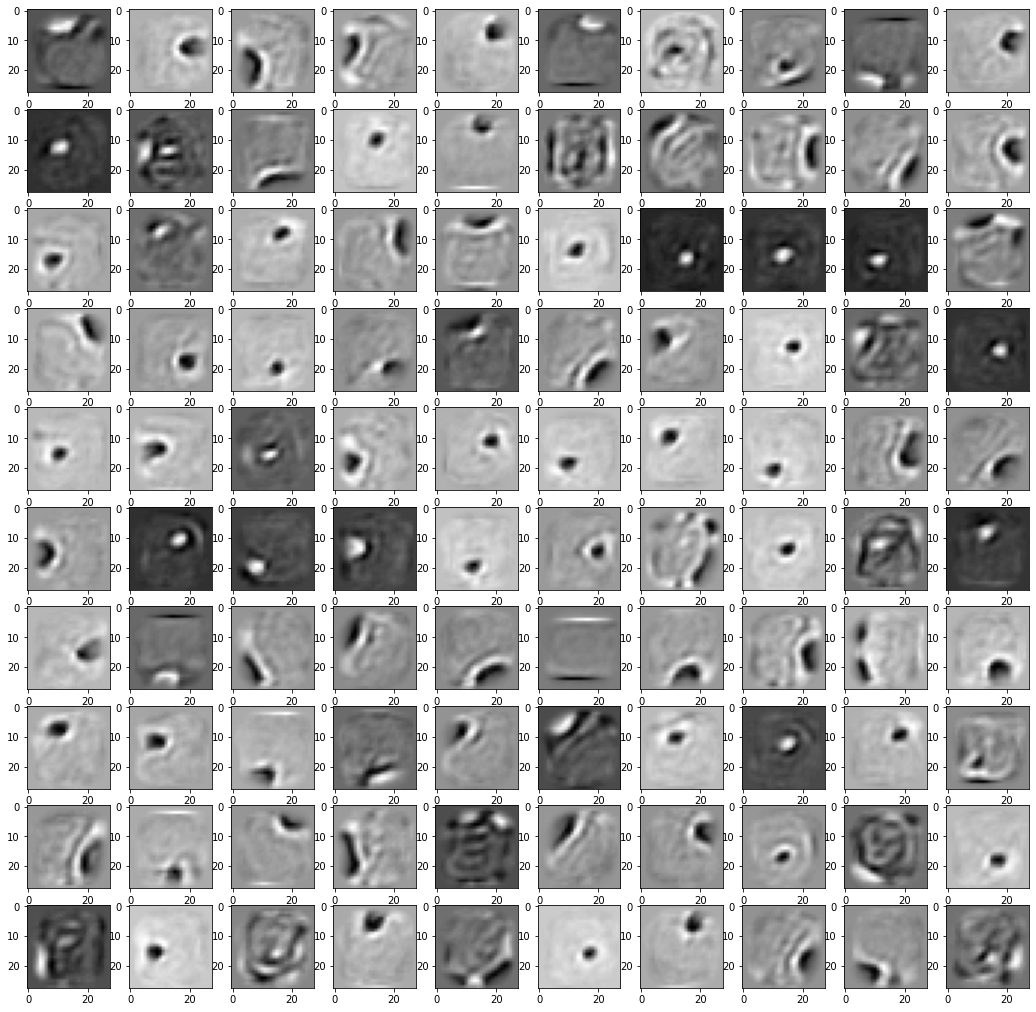

In [16]:
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

# visualising layer 1
learned_weights = dbn.rbm_layers[0].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

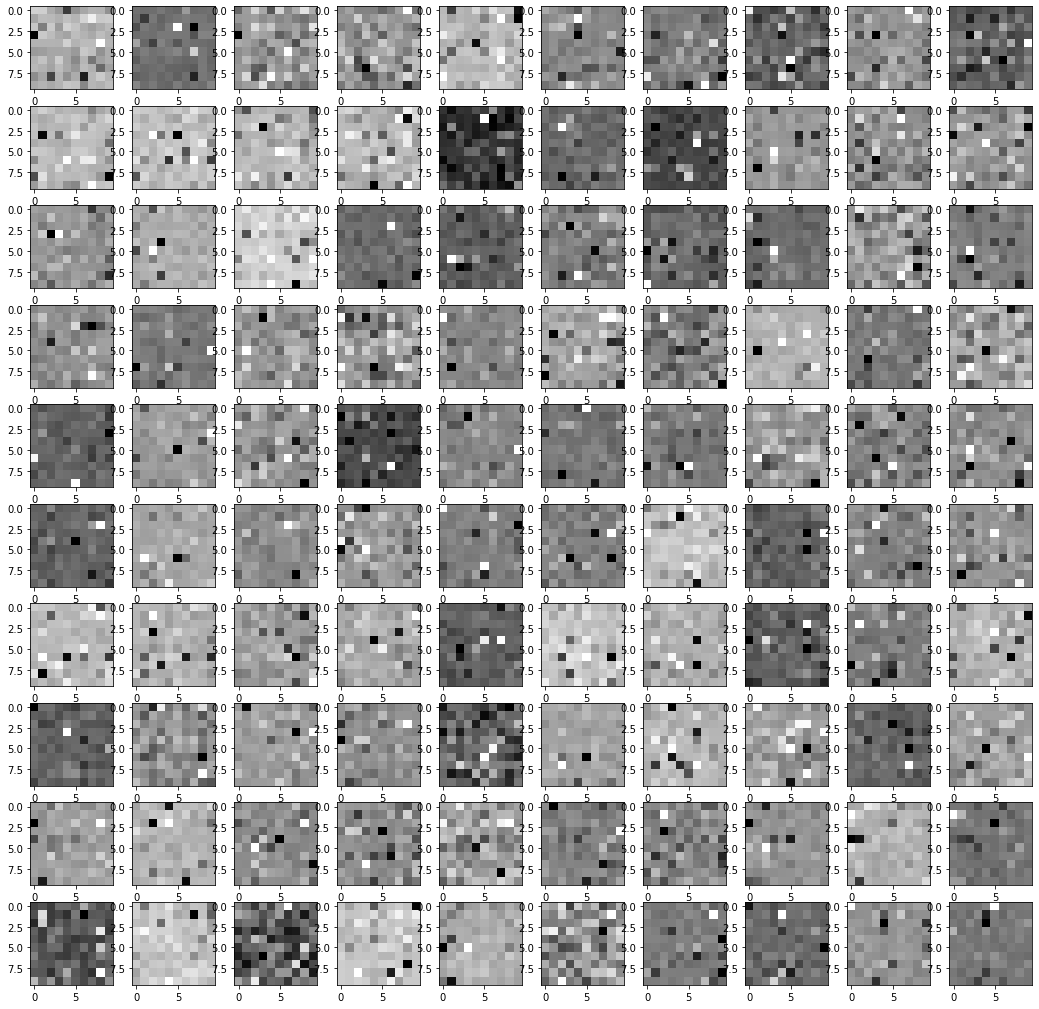

In [17]:
# visualising layer 2
learned_weights = dbn.rbm_layers[1].w.transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(18,18))
for i in range(100): 
    sub = fig.add_subplot(10, 10, i+1)
    sub.imshow(learned_weights[i,:].reshape((10,10)), cmap=plt.cm.gray)
plt.show()

## Train a classification model by placing a softmax layer after the DBN

In [18]:
class DBN_Net(torch.nn.Module):
    def __init__(self, dbn, input_dim, output_dim):
        super(DBN_Net, self).__init__()
        self.dbn = dbn
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = self.dbn.forward(x)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        for epoch in range(epochs):
          for i, (batch, labels) in enumerate(tr_loader):
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = clf(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
          
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          print("Epoch:{}. loss :{}. Accuracy:{}".format(epoch+1, loss.item(), accuracy))
        return y_true, y_pred

dbn_Model = DBN_Net(dbn, HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(dbn_Model.parameters(), lr=1e-3)

In [19]:
y_true, y_pred = dbn_Model.train(tr_loader, ts_loader, optimizer, dbn_Model, criterion)

Epoch:1. loss :0.07562684267759323. Accuracy:91.08999633789062
Epoch:2. loss :0.04462772607803345. Accuracy:92.1199951171875
Epoch:3. loss :0.035871587693691254. Accuracy:92.5199966430664
Epoch:4. loss :0.031911514699459076. Accuracy:92.76000213623047
Epoch:5. loss :0.029725614935159683. Accuracy:92.93000030517578
Epoch:6. loss :0.028382830321788788. Accuracy:93.06999969482422
Epoch:7. loss :0.0275028795003891. Accuracy:93.0999984741211
Epoch:8. loss :0.02690166048705578. Accuracy:93.20999908447266
Epoch:9. loss :0.02647867426276207. Accuracy:93.23999786376953
Epoch:10. loss :0.02617483399808407. Accuracy:93.33999633789062


### Build the confusion matrix :

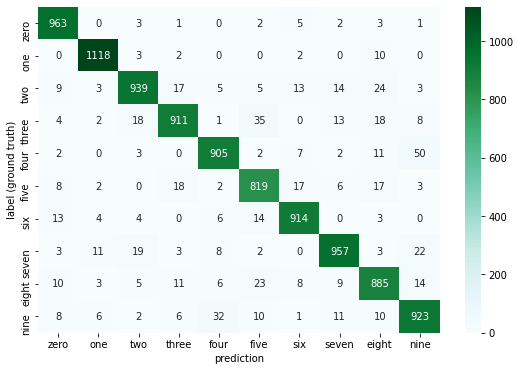

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

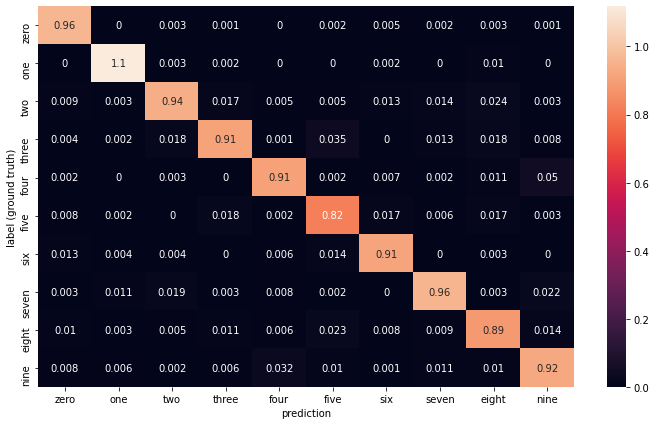

In [21]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Train a classification model taking the DBN hidden states as embbedings.

In [22]:
class EMB_DBN_Net(torch.nn.Module):
    def __init__(self, dbn, input_dim, output_dim):
        super(EMB_DBN_Net, self).__init__()
        self.dbn = dbn
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[0].w, 0, 1))
        self.fl1.bias.data.copy_(self.dbn.rbm_layers[0].hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.fl2.weight.data.copy_(torch.transpose(self.dbn.rbm_layers[1].w, 0, 1))
        self.fl2.bias.data.copy_(self.dbn.rbm_layers[1].hidden_b)
        self.fl3 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)
        x = F.sigmoid(x)
        x = self.fl3(x)

        return F.log_softmax(x, dim=1)

    def train(self, tr_loader, ts_loader, optimizer, clf, criterion, epochs=10):
        for epoch in range(epochs):
          for i, (batch, labels) in enumerate(tr_loader):
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = clf(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
          
          # calculate accuracy
          correct = 0
          total = 0
          y_true = []
          y_pred = []
          for batch, labels in ts_loader:
            batch = Variable(batch.view(-1, VISIBLE_UNITS))
            outputs = clf(batch)
            _, prediction = torch.max(outputs.data, 1)
            y_true.extend(labels)
            y_pred.extend(prediction)
            total += labels.size(0)
            correct += (prediction == labels).sum()
          accuracy = correct / total * 100
          print("Epoch:{}. loss :{}. Accuracy:{}".format(epoch+1, loss.item(), accuracy))
        return y_true, y_pred

emb_dbn_model = EMB_DBN_Net(dbn, VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(emb_dbn_model.parameters(), lr=5e-4)

In [23]:
y_true, y_pred = emb_dbn_model.train(tr_loader, ts_loader, optimizer, emb_dbn_model, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:1. loss :0.06093188002705574. Accuracy:93.76000213623047
Epoch:2. loss :0.02273031510412693. Accuracy:95.09000396728516
Epoch:3. loss :0.012387799099087715. Accuracy:95.81999969482422
Epoch:4. loss :0.007991206832230091. Accuracy:96.20000457763672
Epoch:5. loss :0.005730031058192253. Accuracy:96.55000305175781
Epoch:6. loss :0.004408686421811581. Accuracy:96.70999908447266
Epoch:7. loss :0.003508404828608036. Accuracy:96.88999938964844
Epoch:8. loss :0.0028427764773368835. Accuracy:96.98999786376953
Epoch:9. loss :0.0023237441200762987. Accuracy:97.08999633789062
Epoch:10. loss :0.0019244924187660217. Accuracy:97.16999816894531


### Build the confusion matrix :

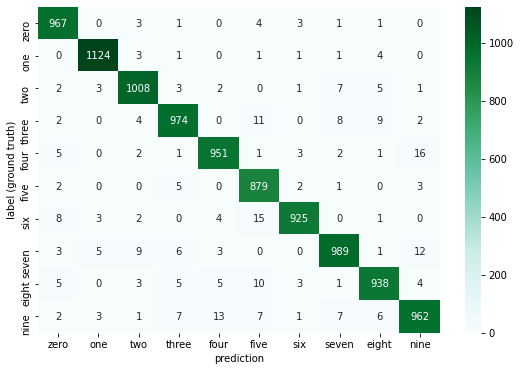

In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

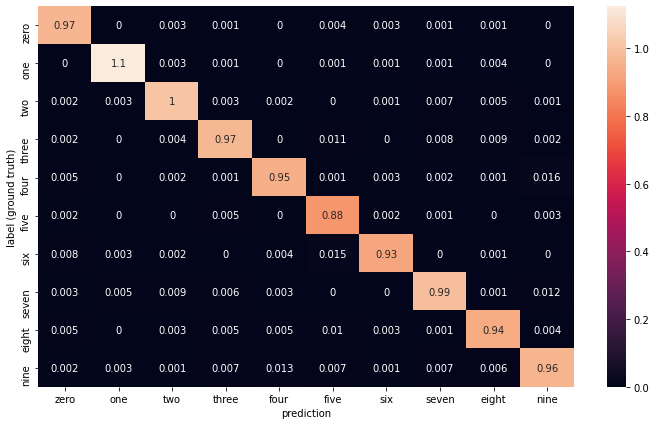

In [25]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

# **Plot the results**

In [26]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [27]:
examples = enumerate(ts_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [28]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data.view(-1, VISIBLE_UNITS))[0])

In [29]:
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data.view(-1, VISIBLE_UNITS))
recon_data_p_DBN1, recon_data_DBN1 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(example_data.view(-1, VISIBLE_UNITS))[0])

### plot raw last batch:

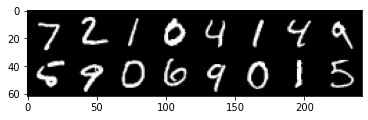

In [30]:
show_adn_save("real",make_grid(example_data.view(example_data.shape[0],1,28,28).data))

### plot reconstructed last batch with propbalitys :

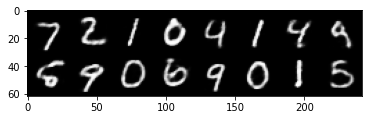

In [31]:
show_adn_save("generate",make_grid(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28).data))

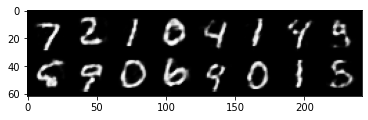

In [32]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

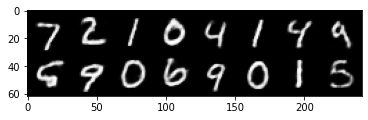

In [33]:
show_adn_save("generate",make_grid(recon_data_p_DBN1.view(recon_data_p_DBN1.shape[0],1,28,28).data))

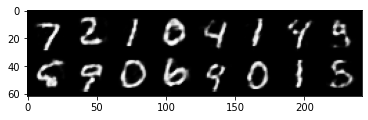

In [34]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

### plot reconstructed last batch with sampled data :

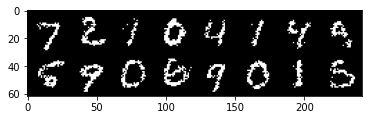

In [35]:
show_adn_save("generate",make_grid(recon_data_RBM.view(recon_data_RBM.shape[0],1,28,28).data))

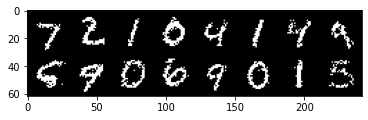

In [36]:
show_adn_save("generate",make_grid(recon_data_DBN1.view(recon_data_DBN1.shape[0],1,28,28).data))

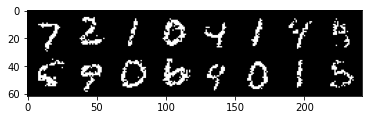

In [37]:
show_adn_save("generate",make_grid(recon_data_DBN.view(recon_data_DBN.shape[0],1,28,28).data))

### plot the reconstruced first batch of test dataset :

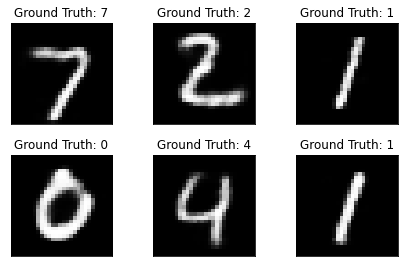

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

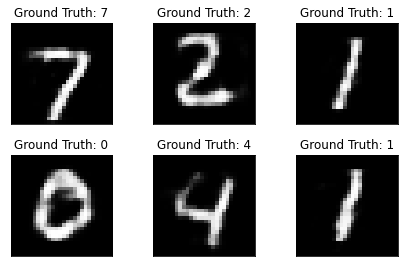

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Try to apply affine transformation to the raw img, in result the classifier will make a wrong prediction on the new img: 

In [40]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data[1].view(-1, VISIBLE_UNITS))

In [41]:
recon_data_p_DBN1, recon_data_DBN1 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN2, recon_data_DBN2 = dbn.rbm_layers[0].h2v(dbn.rbm_layers[1].h2v(dbn.rbm_layers[1].v2h(dbn.rbm_layers[0].v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])[0])[1])

Text(0.5, 1.0, 'DBN, Ground Truth: 2')

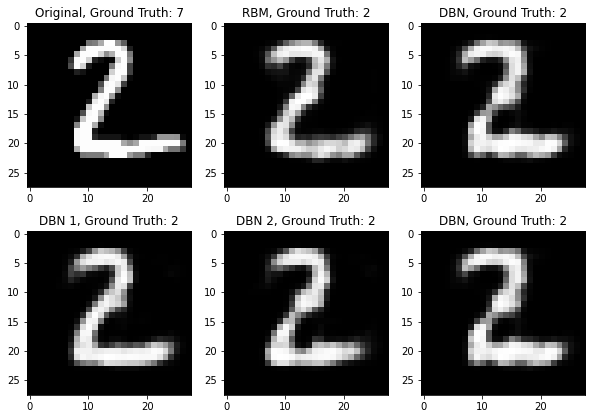

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,3,1)
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Original, Ground Truth: {}".format(example_targets[0]))
plt.subplot(2,3,2)
plt.imshow(recon_data_p_RBM.view((28,28)), cmap='gray', interpolation='none')
plt.title("RBM, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,3)
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,4)
plt.imshow(recon_data_p_DBN1.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN 1, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,5)
plt.imshow(recon_data_p_DBN2.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN 2, Ground Truth: {}".format(example_targets[1]))
plt.subplot(2,3,6)
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("DBN, Ground Truth: {}".format(example_targets[1]))

### Define a composed transforms :

In [43]:
compose = transforms.Compose([transforms.RandomAffine(10, translate = (0.02,0.09)),transforms.Resize((28,28))])

### Apply affine transforms :

Text(0.5, 1.0, 'Ground Truth: 2')

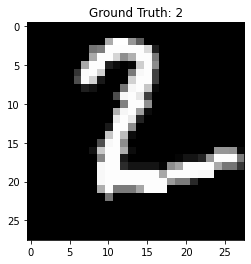

In [44]:
test = example_data[1]
compose(test).shape
plt.imshow(compose(test)[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

### Check the prediction :

In [45]:
batch = Variable(compose(test).view(-1, VISIBLE_UNITS))
outputs = emb_dbn_model(batch)
_, prediction = torch.max(outputs.data, 1)
prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([2])

### reconstruct the new img by RBM

In [46]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(compose(test)[0].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(compose(test)[0].view(-1, VISIBLE_UNITS))

### plot the reconstructed new img

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

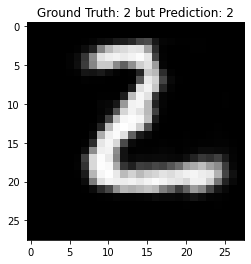

In [47]:
plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

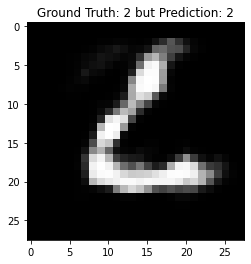

In [48]:
plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

# **Gibbs sampling (from random initial status) on Particular mnist**

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
from PIL import Image

for number in range(10):
  # A number between 0 and 10.
  print("-"*60)
  print("Training dbn for number {}".format(number))
  print("-"*60)

  particular_mnist = []
  limit = tr_dataset.train_data.shape[0]

  for i in range(limit):
      if(tr_dataset.train_labels[i] == number):
          particular_mnist.append(tr_dataset.train_data[i].numpy())

  len(particular_mnist)
  train_data = torch.stack([torch.Tensor(i) for i in particular_mnist])
  train_label = torch.stack([torch.Tensor(number) for i in range(len(particular_mnist))])
  dbn_p = DBN()
  dbn_p.train(train_data,train_label,debug=False)
  

  vi = torch.randn(784)
  for i in range(250):
    #hip, hi = dbn_p.rbm_layers[0].v2h(vi)
    #vip, vi = dbn_p.rbm_layers[0].h2v(hi)
    vip, vi = dbn_p.reconstruct(vi)
    if i > 199: 
      p = vip.view((28,28))
      img = p.data.numpy()
      #plt.imshow(img, cmap='gray')
      #plt.show()
      fname = "/content/test/{}.png".format(i-200)
      plt.imsave(fname, img, cmap='gray')

  images = []
  for i in range(50):
    fname = "/content/test/{}.png".format(i)
    img = Image.open(fname)
    images.append(img)
  path = "/content/drive/MyDrive/gifs/dbn/{}.gif".format(number)
  images[0].save(path, save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
  print("-"*60)
  print("Done, gif image saved in {}".format(path))
  print("-"*60)

------------------------------------------------------------
Training dbn for number 0
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/0.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 1
------------------------------------------------------------
------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/1.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 2
------------------------------------------------------------
------------------------------------------------------------
Done, gif image saved in /content/drive/MyDrive/gifs/dbn/2.gif
------------------------------------------------------------
------------------------------------------------------------
Training dbn for number 3
------------------------------------------------------------
-

# **Reconstruct the uploaded images**:

In [51]:
imgdir = "/content/drive/MyDrive/test_images"
ts_dataset1 = datasets.ImageFolder(imgdir, transform= transforms.Compose(
        [transforms.ToTensor(), transforms.Grayscale(num_output_channels=1), transforms.Resize([28,28])]))
ts_loader1 = torch.utils.data.DataLoader(ts_dataset1, batch_size=1)

examples1 = enumerate(ts_loader1)
batch_idx1, (example_data1, example_targets1) = next(examples1)
img = example_data1[0][0]
img = 1 - img

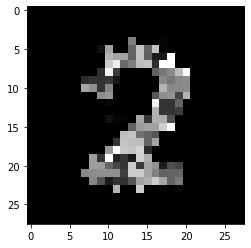

The reconstructed image


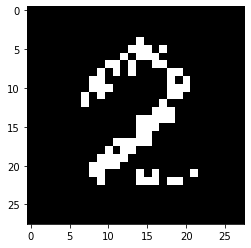

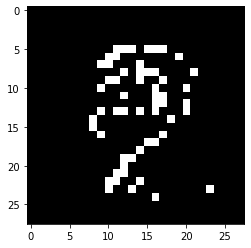

In [52]:
_,reconstructed_img_rbm= dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(img.view(-1, VISIBLE_UNITS))[0])
_,reconstructed_img_dbn= dbn_p.reconstruct(img.view(1,-1))
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
reconstructed_img_dbn = reconstructed_img_dbn.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()
plt.imshow(reconstructed_img_dbn , cmap = 'gray')
plt.show()

In [53]:
batch_idx1, (example_data1, example_targets1) = next(examples1)
img = example_data1[0][0]
img = 1 - img

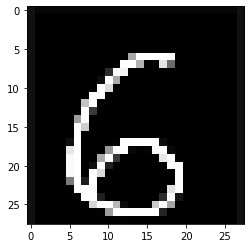

The reconstructed image


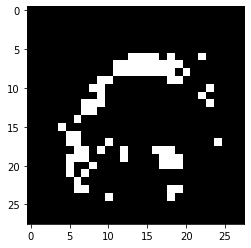

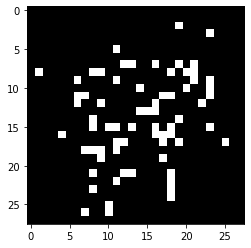

In [54]:
_,reconstructed_img_rbm= dbn.rbm_layers[0].h2v(dbn.rbm_layers[0].v2h(img.view(-1, VISIBLE_UNITS))[0])
_,reconstructed_img_dbn= dbn_p.reconstruct(img.view(1,-1))
reconstructed_img_rbm = reconstructed_img_rbm.view((28,28))
reconstructed_img_dbn = reconstructed_img_dbn.view((28,28))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img_rbm , cmap = 'gray')
plt.show()
plt.imshow(reconstructed_img_dbn , cmap = 'gray')
plt.show()